# Continuous Control with DDPG

---
### 1. Train the agent

Run the next code cell to train the agent. 

In [3]:
from collections import deque
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
import torch
import time

agent = Agent(state_size=33, action_size=4, random_seed=0)
env = UnityEnvironment(file_name='Reacher_V02')# get the default brain
#env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')
brain_name = env.brain_names[0]                    # get the default brain
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
num_agents = len(env_info.agents)

def ddpg(n_episodes=800, max_t=1000, print_every=100):
    scores_100 = deque(maxlen=print_every)
    scores_all = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations              # get the current state for each agent
        scores = np.zeros(num_agents)                     # initialize the score (for each agent)
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send all actions to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done
            scores += env_info.rewards                         # update the score (for each agent)
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            if np.any(dones):
                print(t)
                break 
            states = next_states
            
        agent.learn2()
        score = np.mean(scores)
        scores_100.append(score)
        scores_all.append(score)
        print('\rEpisode {}, Score last 100 episodes: {:.2f}, Score current episode: {:.2f}'\
          .format(i_episode, np.mean(scores_100), score, end="\n"))
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')            
            np.save('scores_all_reacher.npy', scores_all)
    return scores_all

scores = ddpg()


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
/miniconda3/lib/python3.5/site-packages/torch/nn/functional.py:1150: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1, Score last 100: 0.01, Score current episode: 0.01


KeyboardInterrupt: 

### 2. Watch a trained agent


In [ ]:
from unityagents import UnityEnvironment
import numpy as np
from ddpg_agent import Agent
import torch

agent = Agent(state_size=33, action_size=4, random_seed=0)
#load weights
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location=lambda storage, loc: storage))


env = UnityEnvironment(file_name='Reacher_V01')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
state = env_info.vector_observations[0]                  # get the current state (for each agent)
scores = 0;

while True:
    #actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    action = agent.act(state, False) #add noise false
    env_info = env.step(action)[brain_name]        # send the action to the environment
    state = env_info.vector_observations[0]   # get the next state
    done  = env_info.local_done[0]
    scores += env_info.rewards[0]                         # update the score (for each agent)
    if done:                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))
env.close()

### 3. Plot results

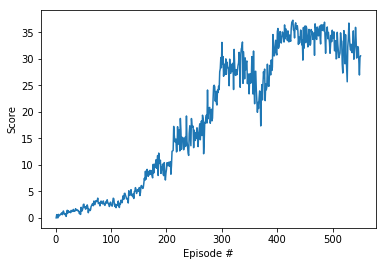

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
scores = np.load('scores_all_reacher.npy')
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

fig.tight_layout()
fig.savefig('output.png', dpi=300)